In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

In [3]:
config_name = 'tunnel'
conf = load_conf(config_name)

In [11]:
# Contains tuple of:
# - params
# - data_pot
# - data_psi2[ |Φ|, Re{Φ}, Im{Φ} ]
# - data_obs[t, prob, prob, E, xmoy, x2moy, pmoy, p2moy]
E = 1283.2037962506  # Energy of particle with 0 potential
dataset = run_with_params(
    config_name,
    gen_variations({
        'V0': [500, E, 1500]
    })
)

In [12]:
def extract(dataset: tuple[dict, np.ndarray, np.ndarray, np.ndarray]) -> tuple[np.ndarray, ...]:
    params, data_pot, data_psi2, data_obs = dataset
    x = data_pot[:,0]
    t = data_obs[:,0]
    H_moy = data_obs[:,3]
    x_moy = data_obs[:,4]
    x2_moy = data_obs[:,5]
    p_moy = data_obs[:,6]
    p2_moy = data_obs[:,7]

    delta_x = np.sqrt(x2_moy - x_moy**2)
    delta_p = np.sqrt(p2_moy - p_moy**2)

    return x, t, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p

# Plots!

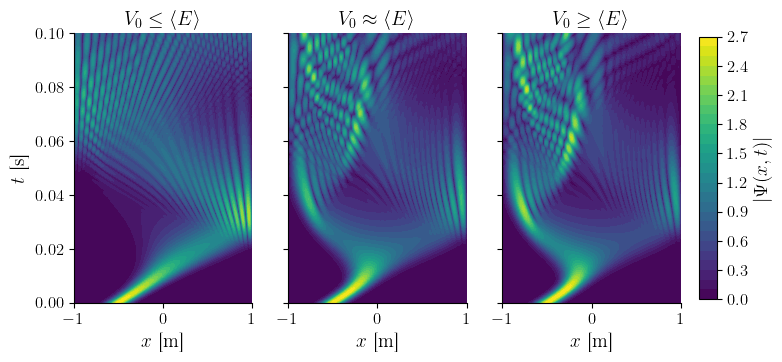

In [46]:
%matplotlib inline

fig, feur = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True)
ax: list[plt.Axes] = feur
magic = [r'\le', r'\approx', r'\ge']
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset):
    x, t, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p = \
        extract((params, data_pot, data_psi2, data_obs))
    X, Y = np.meshgrid(x, t)
    im = ax[i].contourf(X, Y, np.sqrt(data_psi2[:,::3]), levels=32)
    ax[i].set_xlabel(r'$x$ [m]')
    ax[i].set_title(f'$V_0 {magic[i]} \\langle E \\rangle$')

ax[0].set_ylabel(r'$t$ [s]')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.75])
fig.colorbar(im, cax=cbar_ax).set_label(r'$|\Psi(x,t)|$')

In [ ]:
%matplotlib qt
import matplotlib.animation as mpla

plt.figure(figsize=(8, 6))

line1, = plt.plot(data_pot[:,0], data_psi2[0,::3])
line2, = plt.plot(data_pot[:,0], data_psi2[0,1::3])
line3, = plt.plot(data_pot[:,0], data_psi2[0,2::3])
size = data_psi2.shape[0]


def animate(i) -> Any:
    idx = i % size
    line1.set_data(data_pot[:,0], data_psi2[idx,::3])
    line2.set_data(data_pot[:,0], data_psi2[idx,1::3])
    line3.set_data(data_pot[:,0], data_psi2[idx,2::3])

anim = mpla.FuncAnimation(plt.gcf(), animate, interval=20, cache_frame_data=True, frames=size)

plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$|\Psi|^2$')
# plt.ylim(-2, 2)
plt.grid()
plt.tight_layout()